## 
 sieć

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.visualization as ov
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


try:
    data_common = pd.read_excel("AirQualityUCI_outcome.xlsx")
except FileNotFoundError:
    print(
        "BŁĄD: Nie znaleziono pliku AirQualityUCI_outcome.xlsx. Upewnij się, że jest w folderze."
    )
    data_common = None

if data_common is not None:
    features = [
        "PT08.S1(CO)",
        "NMHC(GT)",
        "C6H6(GT)",
        "PT08.S2(NMHC)",
        "NOx(GT)",
        "PT08.S3(NOx)",
        "NO2(GT)",
        "PT08.S4(NO2)",
        "PT08.S5(O3)",
        "T",
        "RH",
        "AH",
    ]
    target = "CO(GT)"

    X_train_raw = data_common[data_common["Set"] == "train"][features].values
    y_train_raw = data_common[data_common["Set"] == "train"][target].values.reshape(
        -1, 1
    )

    X_val_raw = data_common[data_common["Set"] == "validation"][features].values
    y_val_raw = data_common[data_common["Set"] == "validation"][target].values.reshape(
        -1, 1
    )

    X_test_raw = data_common[data_common["Set"] == "test"][features].values
    y_test_raw = data_common[data_common["Set"] == "test"][target].values.reshape(-1, 1)

    scaler_X = StandardScaler().fit(X_train_raw)
    scaler_y = StandardScaler().fit(y_train_raw)

    X_train, y_train = scaler_X.transform(X_train_raw), scaler_y.transform(y_train_raw)
    X_val, y_val = scaler_X.transform(X_val_raw), scaler_y.transform(y_val_raw)
    X_test, y_test = scaler_X.transform(X_test_raw), scaler_y.transform(y_test_raw)

    TIME_STEPS = 10

    def create_sequences(X, y, time_steps=10):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i : (i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    X_val_with_lookback = np.concatenate((X_train[-TIME_STEPS:], X_val))
    y_val_with_lookback = np.concatenate((y_train[-TIME_STEPS:], y_val))

    X_test_with_lookback = np.concatenate((X_val[-TIME_STEPS:], X_test))
    y_test_with_lookback = np.concatenate((y_val[-TIME_STEPS:], y_test))

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
    X_val_seq, y_val_seq = create_sequences(
        X_val_with_lookback, y_val_with_lookback, TIME_STEPS
    )
    X_test_seq, y_test_seq = create_sequences(
        X_test_with_lookback, y_test_with_lookback, TIME_STEPS
    )

    print("Dane AirQuality gotowe.")
    print(f"Train shapes: {X_train_seq.shape}")
    print(f"Val shapes:   {X_val_seq.shape}")
    print(f"Test shapes:  {X_test_seq.shape}")

Dane AirQuality gotowe.
Train shapes: (6539, 10, 12)
Val shapes:   (1404, 10, 12)
Test shapes:  (1404, 10, 12)


In [ ]:
def relu(x, d=False):
    return (x > 0).astype(float) if d else np.maximum(0, x)


def train_mlp_common(X, y, lr, epochs, layers, mom=0.9):

    sz = [X.shape[1]] + layers + [1]
    ws = [
        np.random.randn(sz[i], sz[i + 1]) * np.sqrt(2 / sz[i])
        for i in range(len(sz) - 1)
    ]
    bs = [np.zeros((1, sz[i + 1])) for i in range(len(sz) - 1)]

    vw = [np.zeros_like(w) for w in ws]
    vb = [np.zeros_like(b) for b in bs]

    for _ in range(epochs):

        acts = [X]
        zs = []
        for i in range(len(ws)):
            z = np.dot(acts[-1], ws[i]) + bs[i]
            zs.append(z)

            acts.append(z if i == len(ws) - 1 else relu(z))

        err = acts[-1] - y
        deltas = [err]
        for i in range(len(ws) - 1, 0, -1):
            deltas.append(np.dot(deltas[-1], ws[i].T) * relu(zs[i - 1], d=True))
        deltas.reverse()

        for i in range(len(ws)):
            gw = np.dot(acts[i].T, deltas[i]) / y.shape[0]
            gb = np.mean(deltas[i], axis=0)
            vw[i] = mom * vw[i] - lr * gw
            vb[i] = mom * vb[i] - lr * gb
            ws[i] += vw[i]
            bs[i] += vb[i]
    return ws, bs


def predict_mlp(X, ws, bs):
    curr = X
    for i in range(len(ws)):
        curr = np.dot(curr, ws[i]) + bs[i]
        if i < len(ws) - 1:
            curr = relu(curr)
    return curr


results_mlp = []

test_params = {
    "lr": [0.001, 0.01, 0.05, 0.1],
    "layers": [[10], [10, 10], [20, 10], [32, 16, 8]],
    "momentum": [0.0, 0.5, 0.9, 0.99],
    "epochs": [500, 1000, 2000, 3000],
}


base_mlp = {"lr": 0.01, "layers": [10, 10], "momentum": 0.9, "epochs": 1000}

print("Rozpoczynam badanie MLP (Common)...")
for p_n, p_vs in test_params.items():
    for val in p_vs:
        print(f"MLP Common | {p_n} = {val}")
        for r in range(5):

            cfg = base_mlp.copy()
            if p_n == "lr":
                cfg["lr"] = val
            elif p_n == "layers":
                cfg["layers"] = val
            elif p_n == "momentum":
                cfg["momentum"] = val
            elif p_n == "epochs":
                cfg["epochs"] = val

            ws, bs = train_mlp_common(
                X_train,
                y_train,
                cfg["lr"],
                cfg["epochs"],
                cfg["layers"],
                cfg["momentum"],
            )

            for s_n, Xs, ys in [
                ("Train", X_train, y_train),
                ("Val", X_val, y_val),
                ("Test", X_test, y_test),
            ]:
                p_scaled = predict_mlp(Xs, ws, bs)
                p = scaler_y.inverse_transform(p_scaled)
                t = scaler_y.inverse_transform(ys)

                results_mlp.append(
                    {
                        "model": "MLP",
                        "param": p_n,
                        "val": str(val),
                        "run": r,
                        "set": s_n,
                        "mse": mean_squared_error(t, p),
                        "mae": mean_absolute_error(t, p),
                        "r2": r2_score(t, p),
                    }
                )

df_mlp = pd.DataFrame(results_mlp)
print("Badanie MLP zakończone.")

Rozpoczynam badanie MLP (Common)...
MLP Common | lr = 0.001
MLP Common | lr = 0.01
MLP Common | lr = 0.05
MLP Common | lr = 0.1
MLP Common | layers = [10]
MLP Common | layers = [10, 10]
MLP Common | layers = [20, 10]
MLP Common | layers = [32, 16, 8]
MLP Common | momentum = 0.0
MLP Common | momentum = 0.5
MLP Common | momentum = 0.9
MLP Common | momentum = 0.99
MLP Common | epochs = 500
MLP Common | epochs = 1000
MLP Common | epochs = 2000
MLP Common | epochs = 3000
Badanie MLP zakończone.


In [ ]:
def get_optimizer(name, lr, momentum=0.0):
    if name == "Adam":
        return Adam(learning_rate=lr)
    if name == "SGD":
        return SGD(learning_rate=lr, momentum=momentum)
    if name == "RMSprop":
        return RMSprop(learning_rate=lr, momentum=momentum)
    return Adam(learning_rate=lr)


def run_dl_experiment(model_type):
    dl_results = []

    tests = {
        "layers": [1, 2, 3, 4],
        "units": [16, 32, 64, 128],
        "lr": [0.0001, 0.001, 0.01, 0.05],
        "momentum": [0.0, 0.5, 0.9, 0.99],
    }

    base = {
        "layers": 1,
        "units": 32,
        "lr": 0.001,
        "epochs": 40,
        "optimizer": "Adam",
        "momentum": 0.0,
    }

    print(f"--- Start Deep Learning: {model_type} ---")

    for p_name, p_values in tests.items():
        for val in p_values:
            print(f"{model_type} | {p_name} = {val}")
            for r in range(5):
                cfg = base.copy()
                cfg[p_name] = val

                if p_name == "momentum":
                    cfg["optimizer"] = "SGD"
                    cfg["momentum"] = val

                model = Sequential()
                model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

                for i in range(cfg["layers"]):
                    return_seq = i < cfg["layers"] - 1
                    if model_type == "LSTM":
                        model.add(LSTM(cfg["units"], return_sequences=return_seq))
                    else:
                        model.add(
                            Conv1D(cfg["units"], 3, padding="same", activation="relu")
                        )

                if model_type == "CNN":
                    model.add(Flatten())

                model.add(Dense(1))

                opt = get_optimizer(cfg["optimizer"], cfg["lr"], cfg["momentum"])
                model.compile(optimizer=opt, loss="mse")

                es = EarlyStopping(
                    monitor="val_loss", patience=8, restore_best_weights=True
                )

                model.fit(
                    X_train_seq,
                    y_train_seq,
                    validation_data=(X_val_seq, y_val_seq),
                    epochs=cfg["epochs"],
                    batch_size=64,
                    callbacks=[es],
                    verbose=0,
                )

                for s_name, Xs, ys in [
                    ("Train", X_train_seq, y_train_seq),
                    ("Val", X_val_seq, y_val_seq),
                    ("Test", X_test_seq, y_test_seq),
                ]:
                    preds_scaled = model.predict(Xs, verbose=0)
                    y_p = scaler_y.inverse_transform(preds_scaled)
                    y_t = scaler_y.inverse_transform(ys)

                    dl_results.append(
                        {
                            "model": model_type,
                            "param": p_name,
                            "val": str(val),
                            "run": r,
                            "set": s_name,
                            "mse": mean_squared_error(y_t, y_p),
                            "mae": mean_absolute_error(y_t, y_p),
                            "r2": r2_score(y_t, y_p),
                        }
                    )
    return dl_results


res_lstm = run_dl_experiment("LSTM")
res_cnn = run_dl_experiment("CNN")

df_dl = pd.DataFrame(res_lstm + res_cnn)
df_total = pd.concat([df_mlp, df_dl], ignore_index=True)


df_total.to_excel("AirQuality_Final_Results_Raw.xlsx", index=False)
print("Wyniki zapisane.")

--- Start Deep Learning: LSTM ---
LSTM | layers = 1
LSTM | layers = 2
LSTM | layers = 3
LSTM | layers = 4
LSTM | units = 16
LSTM | units = 32
LSTM | units = 64
LSTM | units = 128
LSTM | lr = 0.0001
LSTM | lr = 0.001
LSTM | lr = 0.01
LSTM | lr = 0.05
LSTM | momentum = 0.0
LSTM | momentum = 0.5
LSTM | momentum = 0.9
LSTM | momentum = 0.99
--- Start Deep Learning: CNN ---
CNN | layers = 1
CNN | layers = 2
CNN | layers = 3
CNN | layers = 4
CNN | units = 16
CNN | units = 32
CNN | units = 64
CNN | units = 128
CNN | lr = 0.0001
CNN | lr = 0.001
CNN | lr = 0.01
CNN | lr = 0.05
CNN | momentum = 0.0
CNN | momentum = 0.5
CNN | momentum = 0.9
CNN | momentum = 0.99
Wyniki zapisane.


In [ ]:
def objective(trial):

    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.3)
    momentum = trial.suggest_float("momentum", 0.0, 0.99)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    model = Sequential()
    model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

    for i in range(n_layers):
        return_seq = i < n_layers - 1
        model.add(LSTM(n_units, return_sequences=return_seq))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    if optimizer_name == "Adam":
        opt = Adam(learning_rate=lr)
    else:
        opt = SGD(learning_rate=lr, momentum=momentum)

    model.compile(optimizer=opt, loss="mse")

    model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=25,
        batch_size=64,
        verbose=0,
    )

    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)
    return val_loss


print("--- Optuna Optimization (AirQuality) ---")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)
best_params_common = study.best_params


try:
    print("Generowanie wizualizacji Optuna...")
    fig1 = ov.plot_optimization_history(study)
    fig1.show()

    fig2 = ov.plot_param_importances(study)
    fig2.show()
except Exception as e:
    print(f"Nie udało się wygenerować wykresów Optuna (brak plotly?): {e}")

[I 2026-01-16 11:12:42,856] A new study created in memory with name: no-name-851fca85-d56d-422e-a146-7db2f035345f


--- Optuna Optimization (AirQuality) ---


[I 2026-01-16 11:12:55,148] Trial 0 finished with value: 0.5837006568908691 and parameters: {'n_layers': 1, 'n_units': 110, 'lr': 0.0005180551564694148, 'dropout': 0.011621054292238564, 'momentum': 0.7289303727297436, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5837006568908691.
[I 2026-01-16 11:13:06,849] Trial 1 finished with value: 0.5590100884437561 and parameters: {'n_layers': 1, 'n_units': 58, 'lr': 0.008905914114670867, 'dropout': 0.27809444410640594, 'momentum': 0.24222413863788164, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.5590100884437561.
[I 2026-01-16 11:13:27,978] Trial 2 finished with value: 0.5767317414283752 and parameters: {'n_layers': 2, 'n_units': 85, 'lr': 0.007358130174022686, 'dropout': 0.03700095000234614, 'momentum': 0.04188454301946628, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.5590100884437561.
[I 2026-01-16 11:13:57,257] Trial 3 finished with value: 0.5417037010192871 and parameters: {'n_layers': 2, 'n_units': 119, 'lr': 0.0001348237

Best params: {'n_layers': 3, 'n_units': 71, 'lr': 0.00013215126425531387, 'dropout': 0.03847677529148904, 'momentum': 0.4343735383839097, 'optimizer': 'Adam'}
Generowanie wizualizacji Optuna...
Nie udało się wygenerować wykresów Optuna (brak plotly?): Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.


/tmp/ipykernel_2004/250563184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


Generowanie wykresów wpływu parametrów...


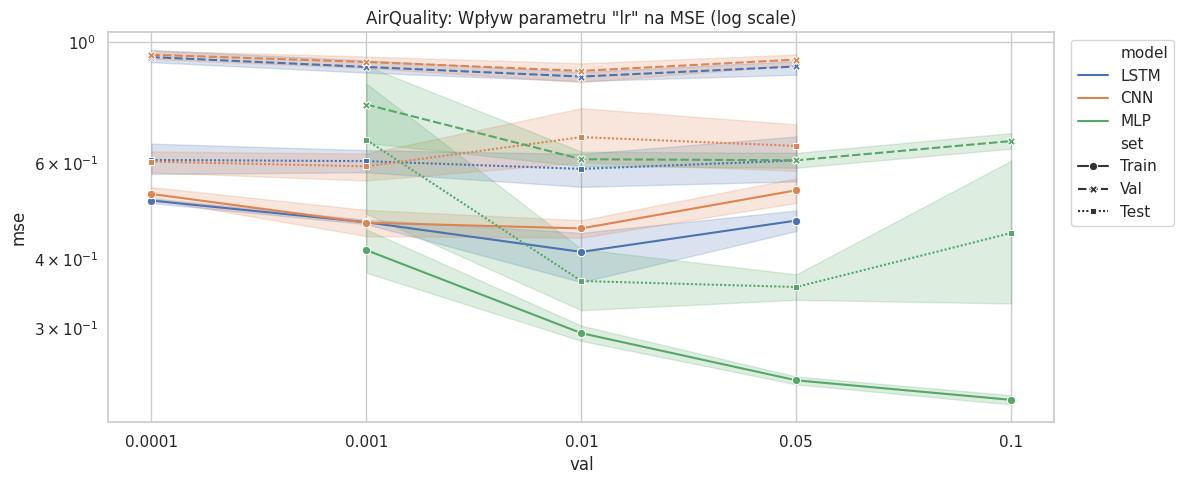

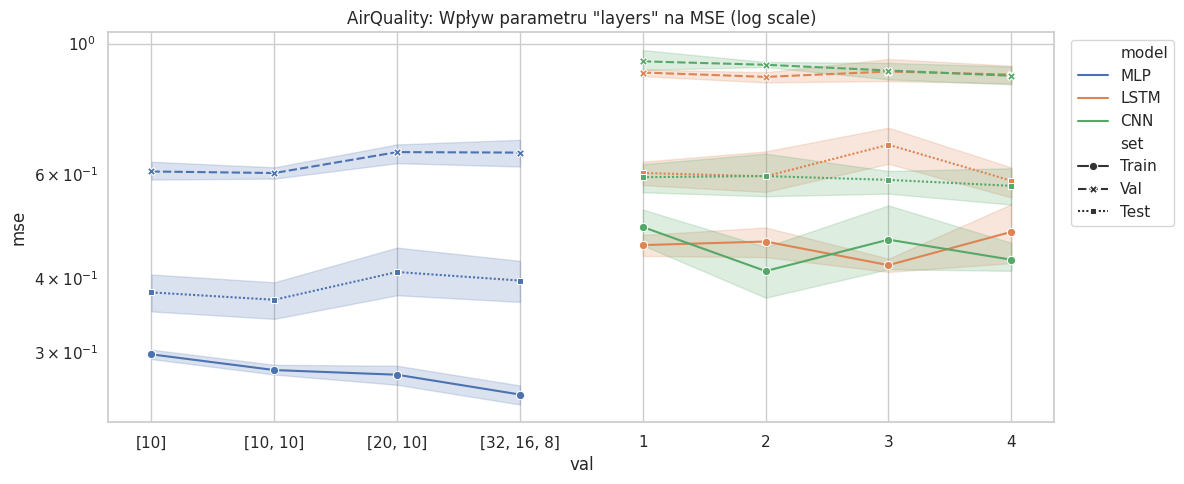

/tmp/ipykernel_2004/250563184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


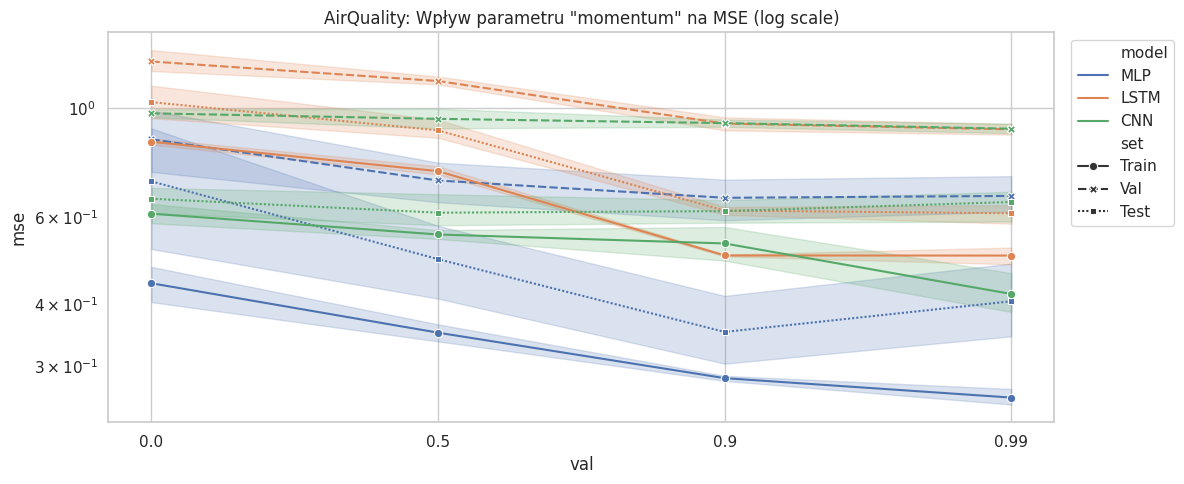

/tmp/ipykernel_2004/250563184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


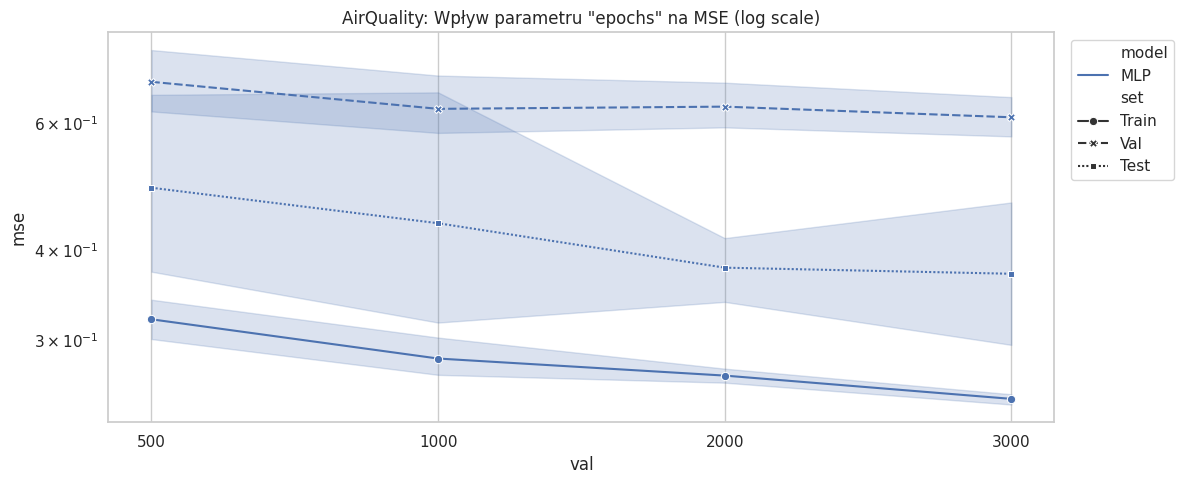

/tmp/ipykernel_2004/250563184.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["val_num"] = pd.to_numeric(subset_df["val"])


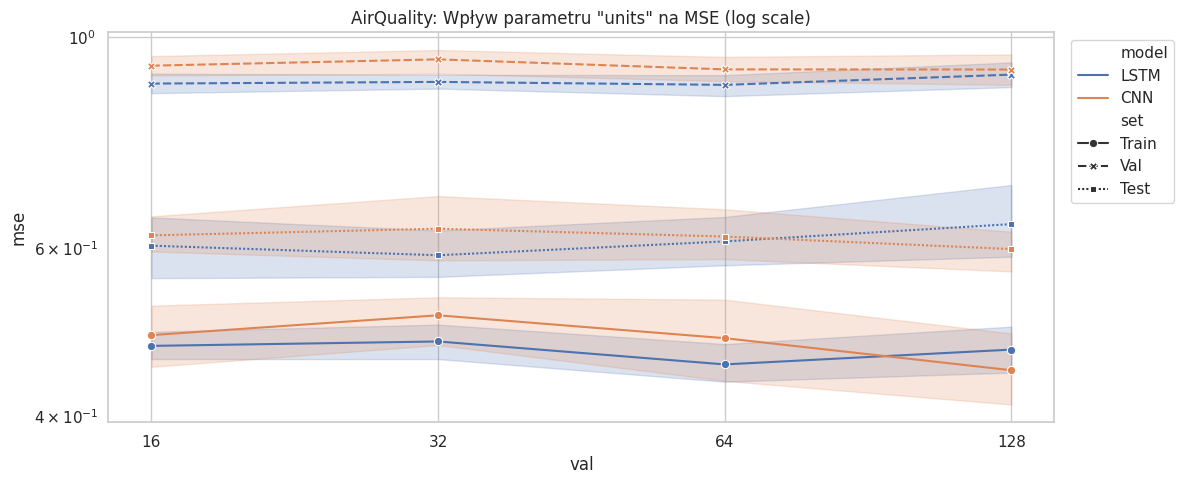

Generowanie map ciepła (Heatmaps)...


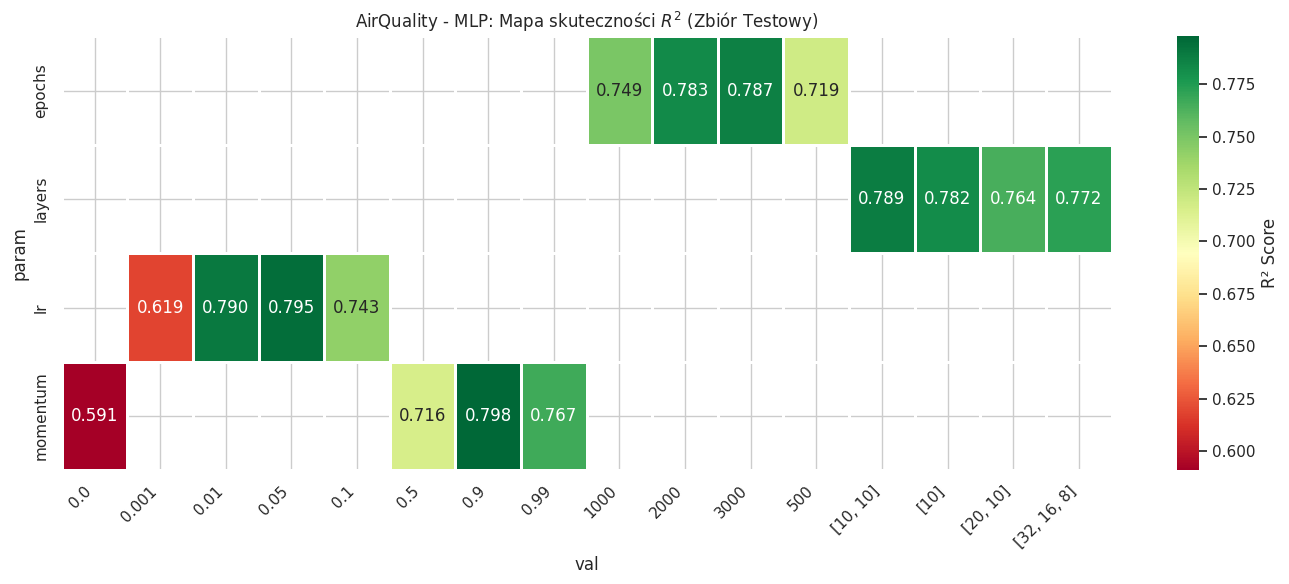

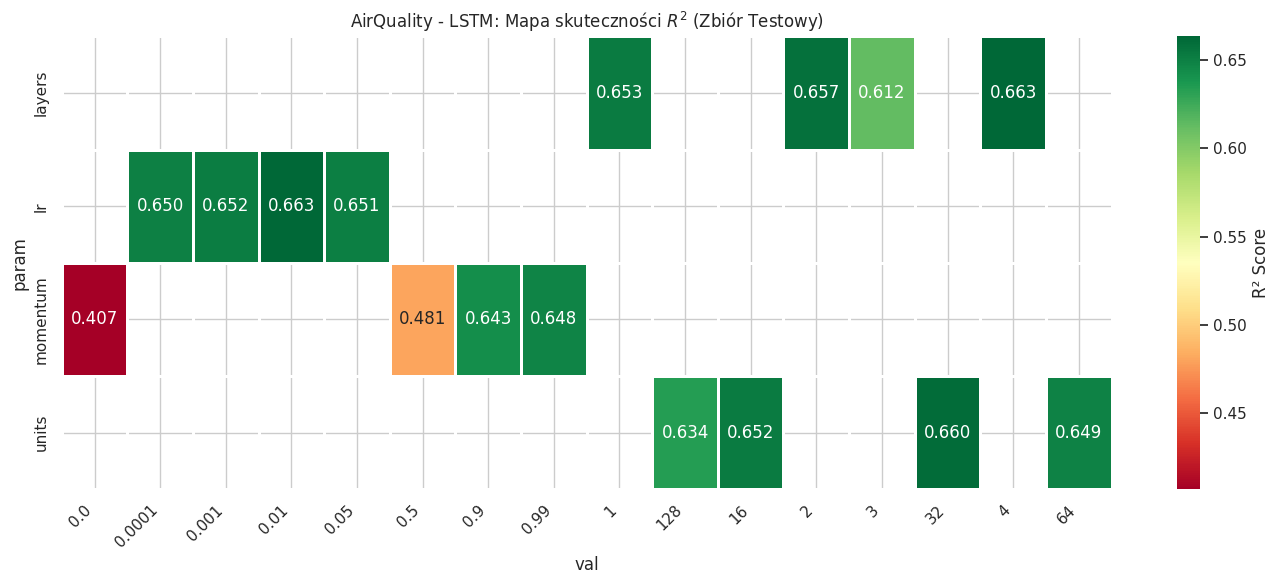

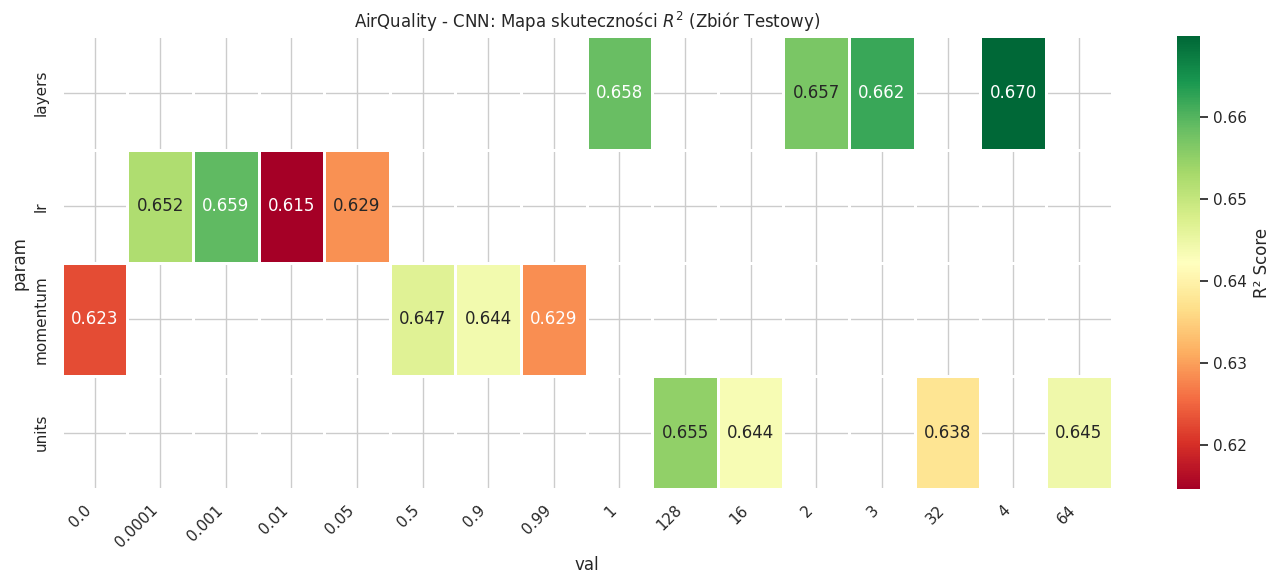

Analiza reszt dla najlepszego modelu...


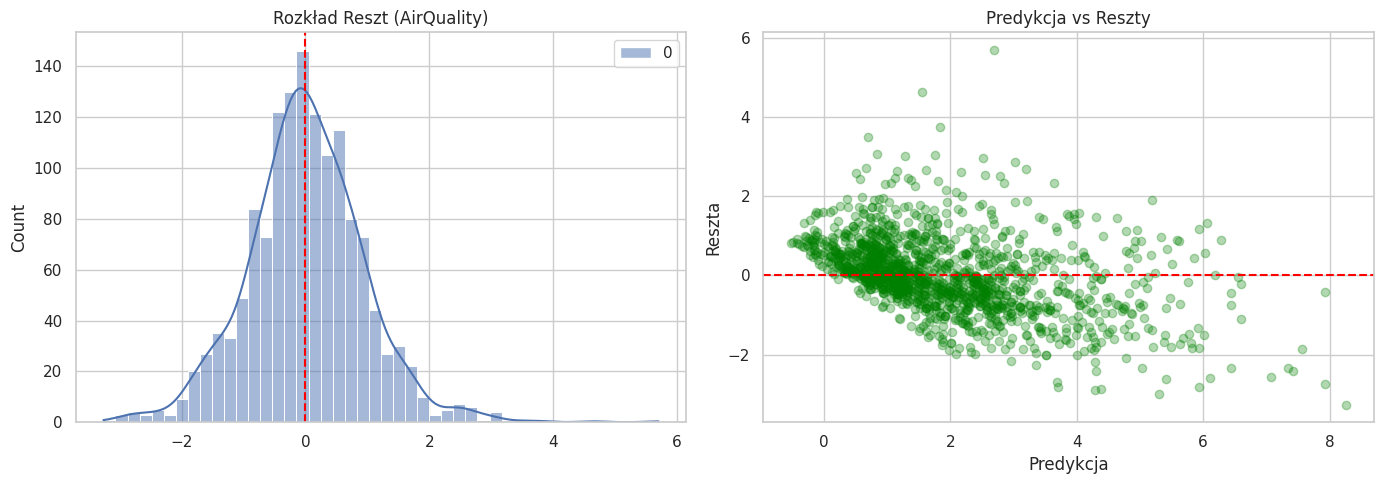

Gotowe! Tabela statystyk zapisana w: AirQuality_Final_Summary_Stats.xlsx


In [ ]:
df_plot = df_total.copy()
df_plot["set"] = df_plot["set"].str.capitalize()


params_to_plot = df_plot["param"].unique()

print("Generowanie wykresów wpływu parametrów...")
for p in params_to_plot:
    plt.figure(figsize=(12, 5))
    subset_df = df_plot[df_plot["param"] == p]

    try:
        subset_df["val_num"] = pd.to_numeric(subset_df["val"])
        subset_df = subset_df.sort_values("val_num")
    except:
        pass

    sns.lineplot(
        data=subset_df,
        x="val",
        y="mse",
        hue="model",
        style="set",
        markers=True,
        dashes=True,
        err_style="band",
    )
    plt.title(f'AirQuality: Wpływ parametru "{p}" na MSE (log scale)')
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


print("Generowanie map ciepła (Heatmaps)...")
for model_name in df_plot["model"].unique():
    test_data = df_plot[(df_plot["model"] == model_name) & (df_plot["set"] == "Test")]

    if not test_data.empty:

        pivot_data = test_data.pivot_table(index="param", columns="val", values="r2")

        if not pivot_data.empty:
            fig, ax = plt.subplots(figsize=(14, 6))
            sns.heatmap(
                pivot_data,
                annot=True,
                cmap="RdYlGn",
                fmt=".3f",
                linewidths=1,
                linecolor="white",
                cbar_kws={"label": "R² Score"},
                ax=ax,
            )
            plt.title(
                f"AirQuality - {model_name}: Mapa skuteczności $R^2$ (Zbiór Testowy)"
            )
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()


print("Analiza reszt dla najlepszego modelu...")
best_model = Sequential()
best_model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

n_layers = best_params_common.get("n_layers", 2)
n_units = best_params_common.get("n_units", 64)
drop = best_params_common.get("dropout", 0.0)
opt_name = best_params_common.get("optimizer", "Adam")
lr_val = best_params_common.get("lr", 0.001)
mom_val = best_params_common.get("momentum", 0.0)

for i in range(n_layers):
    best_model.add(LSTM(n_units, return_sequences=(i < n_layers - 1)))
    if drop > 0:
        best_model.add(Dropout(drop))

best_model.add(Dense(1))


if opt_name == "SGD":
    opt = SGD(learning_rate=lr_val, momentum=mom_val)
else:
    opt = Adam(learning_rate=lr_val)

best_model.compile(optimizer=opt, loss="mse")
best_model.fit(X_train_seq, y_train_seq, epochs=40, batch_size=64, verbose=0)


y_pred_sc = best_model.predict(X_test_seq, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_sc)
y_true = scaler_y.inverse_transform(y_test_seq)
residuals = y_true - y_pred


fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, kde=True, ax=ax[0], color="green")
ax[0].set_title("Rozkład Reszt (AirQuality)")
ax[0].axvline(0, color="red", linestyle="--")

ax[1].scatter(y_pred, residuals, alpha=0.3, color="green")
ax[1].axhline(0, color="red", linestyle="--")
ax[1].set_title("Predykcja vs Reszty")
ax[1].set_xlabel("Predykcja")
ax[1].set_ylabel("Reszta")
plt.tight_layout()
plt.show()


summary_table = df_total.groupby(["model", "param", "val", "set"])[
    ["mse", "mae", "r2"]
].agg(["mean", "std", "max"])
summary_table = summary_table.round(4)

file_name = "AirQuality_Final_Summary_Stats.xlsx"
with pd.ExcelWriter(file_name) as writer:
    summary_table.to_excel(writer, sheet_name="Aggregated Stats")
    df_total.to_excel(writer, sheet_name="Raw Data")

print(f"Gotowe! Tabela statystyk zapisana w: {file_name}")